In [1]:
from simple.ohlc import debounce, midPrice, TTrade
from simple.plotly import chartFigure
from simple.funcs import symlog, vPIN, cPIN, tickSpeed
from simple.pretty import pmap
from simple.jurik import JRSX, JTPO, JCFB
from simple.ehlers import reflex
import numpy as np

import matplotlib.pyplot as plt

In [2]:
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.dpi'] = 80
plt.rcParams['figure.subplot.left'] = 0.04
plt.rcParams['figure.subplot.right'] = 0.96
plt.rcParams['figure.subplot.top'] = 0.96
plt.rcParams['figure.subplot.bottom'] = 0.04
plt.rcParams['axes.grid'] = False
plt.rcParams['image.aspect'] = 'auto'

In [3]:
T = np.load('data/ETHUSDT.2022-05-08.tick.npz')['ETHUSDT'].view(np.recarray)
T[-5:]

rec.array([('2022-05-08T00:59:59.571000', 95815, 2617.99,   -2.),
           ('2022-05-08T00:59:59.584000', 95816, 2617.99,   -2.),
           ('2022-05-08T00:59:59.596000', 95817, 2617.99,   -2.),
           ('2022-05-08T00:59:59.706000', 95818, 2618.  ,   32.),
           ('2022-05-08T00:59:59.826000', 95819, 2618.  , 1912.)],
          dtype={'names':['DateTimeA','LocalTimeA','PriceA','VolumeA'], 'formats':['<M8[us]','<i8','<f8','<f8'], 'offsets':[0,8,16,24], 'itemsize':40})

In [4]:
C = debounce(T)
C[-5:]

rec.array([('2022-05-08T00:59:57.402000', 12593, 2618.405,       0, 1.3980e+03, 1398.,  0.0000e+00,  2,  2,  0),
           ('2022-05-08T00:59:57.418999', 12594, 2618.435,       0, 1.9920e+03, 1992.,  0.0000e+00,  1,  1,  0),
           ('2022-05-08T00:59:58.848000', 12595, 2618.165, 1429001, 6.0580e+03, 2123., -3.9350e+03, 46, 19, 27),
           ('2022-05-08T00:59:58.848000', 12596, 2618.115,       0, 3.0000e+00,    0., -3.0000e+00,  1,  0,  1),
           ('1970-01-01T00:00:00.000000', 12597, 2618.015,  978000, 3.3762e+04, 2243., -3.1519e+04, 27,  5, 22)],
          dtype=[('DT', '<M8[us]'), ('Index', '<i8'), ('Price', '<f8'), ('Duration', '<m8[us]'), ('Volume', '<f8'), ('BuySize', '<f8'), ('SellSize', '<f8'), ('Count', '<i8'), ('BuyCount', '<i8'), ('SellCount', '<i8')])

In [5]:
T.dtype = np.dtype((np.record, {'names': ['DateTime', 'LocalTime', 'Price', 'Volume'],
                                'formats': ['<M8[us]', 'int64', '<f8', '<f8'],
                                'offsets': [0, 8, 16, 24],
                                'itemsize': 40}))
T

rec.array([('2022-05-08T00:01:00.335000',     0, 2636.  ,    6.),
           ('2022-05-08T00:01:00.335000',     1, 2636.  ,    4.),
           ('2022-05-08T00:01:00.668000',     2, 2636.  ,   96.), ...,
           ('2022-05-08T00:59:59.596000', 95817, 2617.99,   -2.),
           ('2022-05-08T00:59:59.706000', 95818, 2618.  ,   32.),
           ('2022-05-08T00:59:59.826000', 95819, 2618.  , 1912.)],
          dtype={'names':['DateTime','LocalTime','Price','Volume'], 'formats':['<M8[us]','<i8','<f8','<f8'], 'offsets':[0,8,16,24], 'itemsize':40})

In [6]:
Buy = T[T.Volume > 0]
Sell = T[T.Volume < 0]

In [7]:
len(T), len(C)

(95820, 12598)

In [8]:
C.Volume = C.BuySize + C.SellSize
Buy = C[C.Volume > 0]
Sell = C[C.Volume < 0]
Sell[-5:]

rec.array([('2022-05-08T00:59:57.149000', 12590, 2618.425,  819000, -9.3230e+03, 1092., -1.0415e+04, 84,  5, 79),
           ('2022-05-08T00:59:57.186999', 12591, 2618.285,   22999, -1.1100e+02,  410., -5.2100e+02,  8,  2,  6),
           ('2022-05-08T00:59:58.848000', 12595, 2618.165, 1429001, -1.8120e+03, 2123., -3.9350e+03, 46, 19, 27),
           ('2022-05-08T00:59:58.848000', 12596, 2618.115,       0, -3.0000e+00,    0., -3.0000e+00,  1,  0,  1),
           ('1970-01-01T00:00:00.000000', 12597, 2618.015,  978000, -2.9276e+04, 2243., -3.1519e+04, 27,  5, 22)],
          dtype=[('DT', '<M8[us]'), ('Index', '<i8'), ('Price', '<f8'), ('Duration', '<m8[us]'), ('Volume', '<f8'), ('BuySize', '<f8'), ('SellSize', '<f8'), ('Count', '<i8'), ('BuyCount', '<i8'), ('SellCount', '<i8')])

In [9]:
# indexed chart without bidask
chartFigure(height=500,
    Sell=dict(x=Sell.Index, y=Sell.Price, color='red', mode='markers', size=-symlog(Sell.Volume)-1, opacity=0.75),
    Buy=dict(x=Buy.Index, y=Buy.Price, color='green', mode='markers', size=symlog(Buy.Volume)-1, opacity=0.75),
)

FigureWidgetResampler({
    'data': [{'marker': {'color': 'red',
                         'opacity': 0.75,
   …

In [10]:
func = {
    'RSX': lambda period: JRSX(C.Price, period+20),
    'TPO': lambda period: JTPO(C.Price, period),
    'CFB': lambda period: JCFB(C.Price, 7, period),
    'Reflex': lambda period: reflex(C.Price, period)
    #'Speed': lambda period: tickSpeed(C.Price, period)
}

In [11]:
P = range(10, 1000, 10)
F = {name: pmap(func[name], P) for name in func}

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

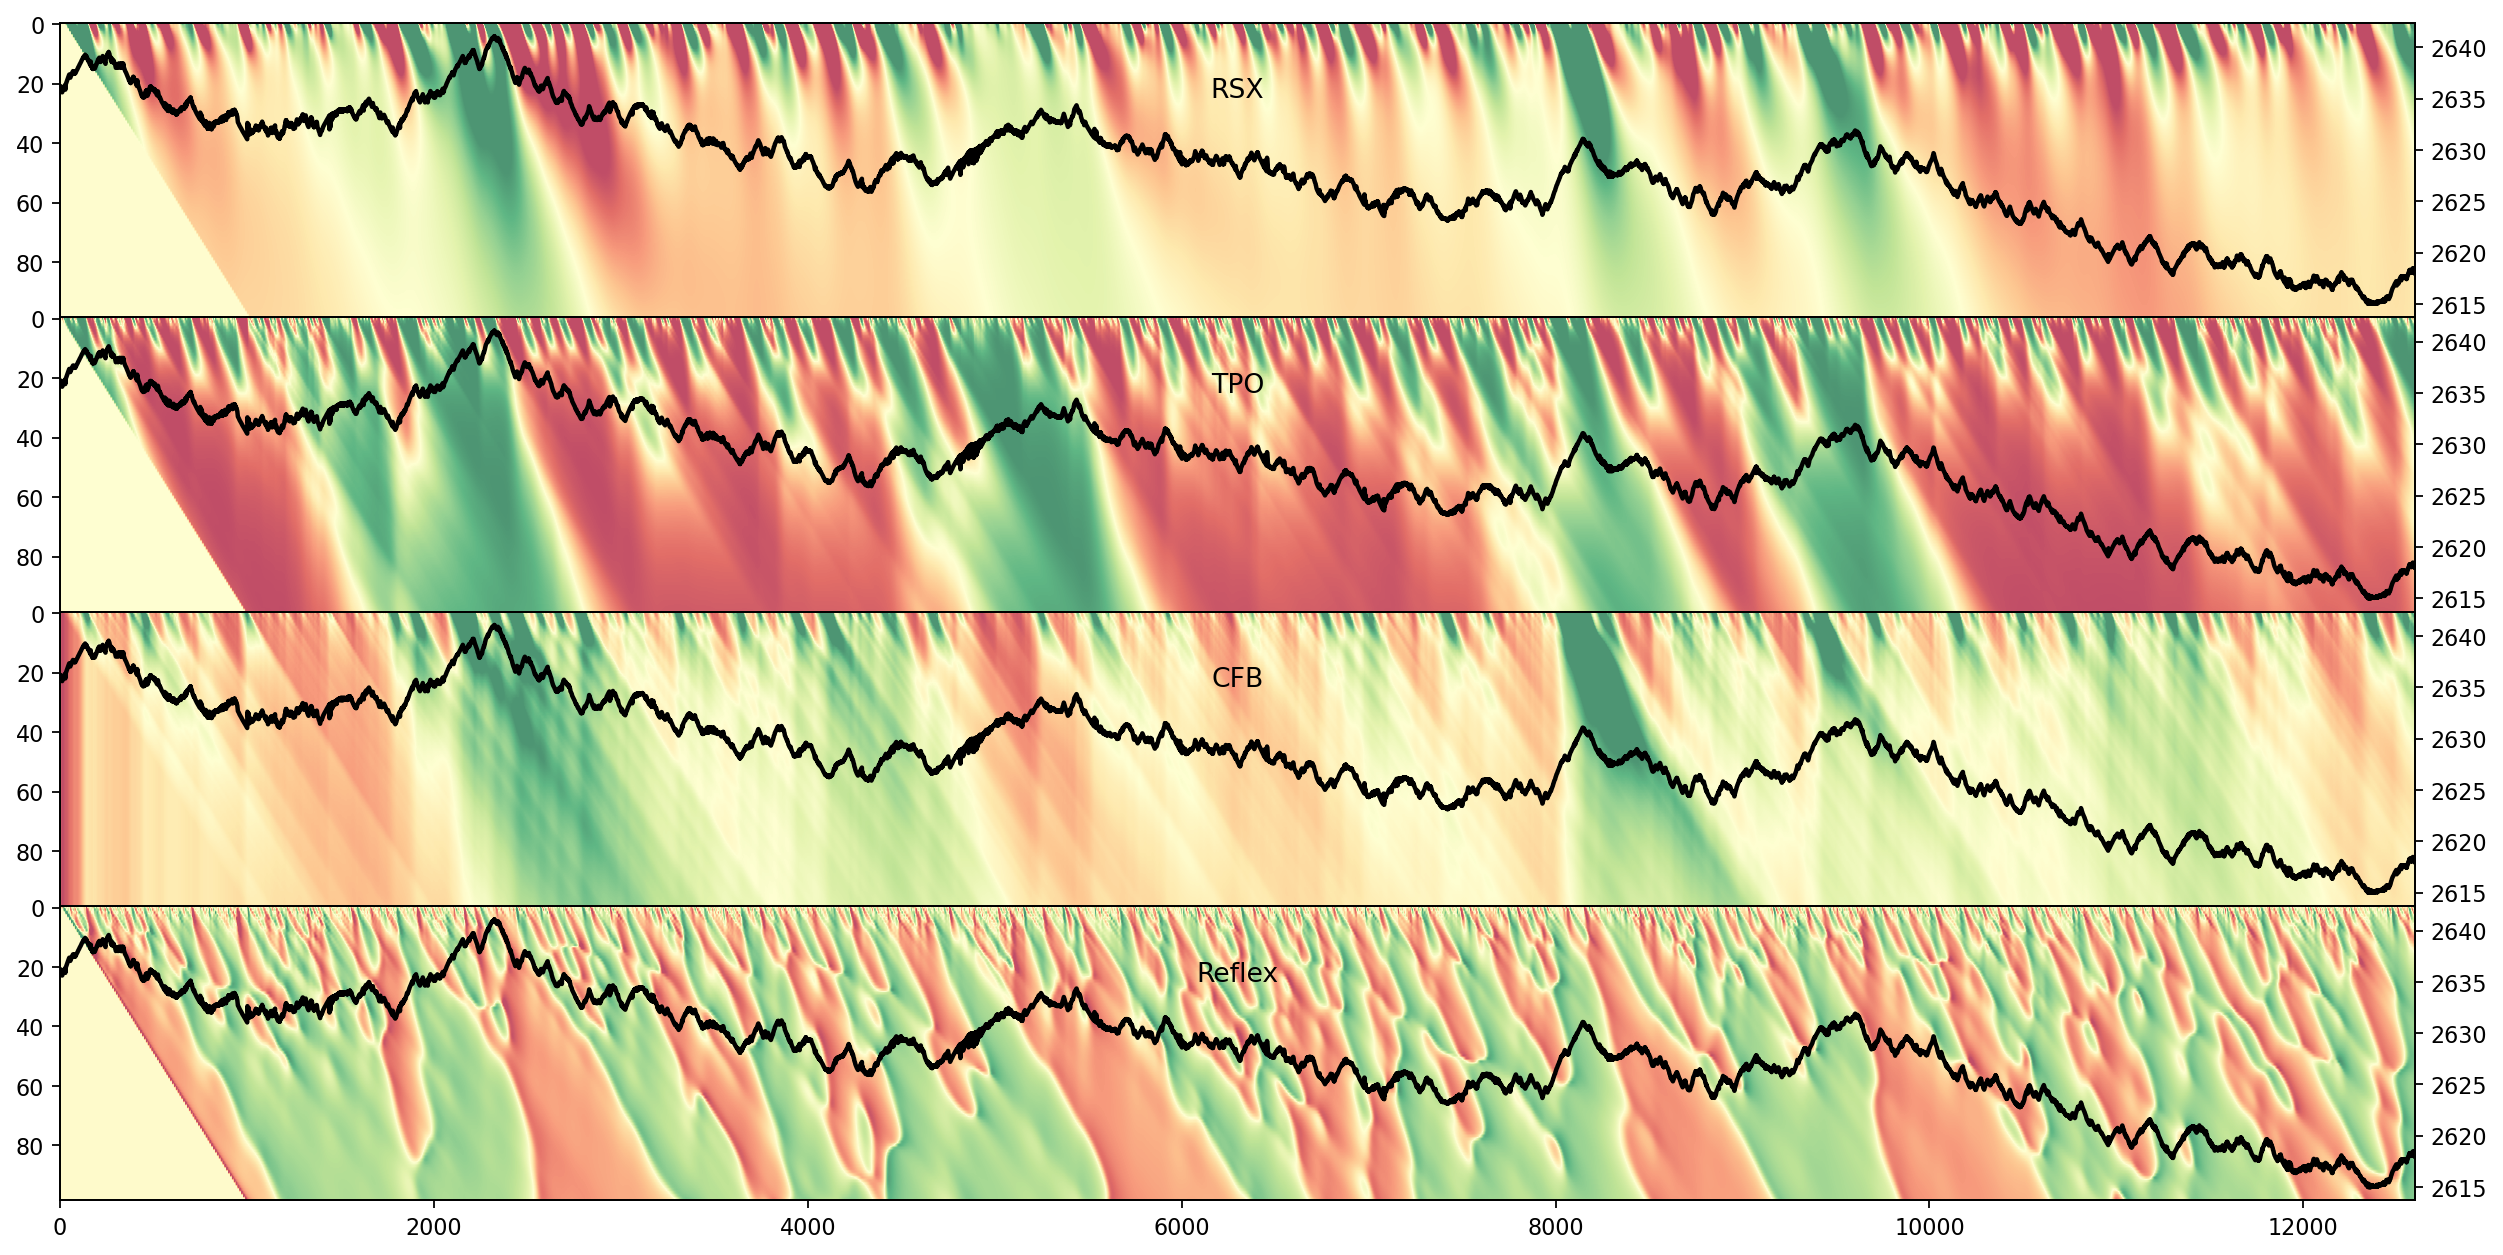

In [18]:
fig, axes = plt.subplots(len(func), 1, figsize=(16, len(func)*2), sharex='col')
fig.subplots_adjust(hspace=0)

for name, ax in zip(func, axes):
    X = F[name][50]
    low, high = np.percentile(X, q=0.05), np.percentile(X, q=99.95)
    ax.imshow(F[name], cmap='RdYlGn', vmin=low, vmax=high, alpha=0.7)
    ax.set_title(name, y=0.7)
    ax.twinx().plot(C.Price, linewidth=2, color='black')